# Grupowanie win pod względem ich podobieństwa
Jako przykład zastosowania algorytmu HDBSCAN* posłuży zbiór danych pochodzący z UCI Machine Learning Repository i dotyczy on jakości poszczególnych rodzajów wina. Cały zbiór danych podzielony jest na dwa pliki - dane dotyczące wina białego i czerwonego. Nazwa "Vinho Verde", dosłownie "*wino zielone*" określa różne rodzaje młodych win pochodzących z Portugalii. Odnosi się ona do młodości i świeżości wina, a nie do koloru, ponieważ tego typu trunek może być biały, czerwony, a niekiedy również różowy. Większość z tych win należy pić póki są świeże, a więc mają między 9 a 18 miesięcy. 

Wykorzystując zgromadzone dane zastosowany zostanie algorytm HDBSCAN* który pozwoli określić, które z rodzajów win są do siebie podobne. Zebrane dane są zanonimizowane, jednakże w rzeczywistym środowisku, mając etykiety każdego z trunków, można byłoby stworzyć silnik odpowiedni rekomendacyjny. Tego typu rozwiązanie pozwoliłoby zasugerować koneserowi, które butelki mogłyby go zainteresować, bazując na jego dotychczasowych preferencjach.  

Oba zbiory danych są zanonimizowane, dlatego też dostępne są tylko zmienne fizykochemiczne i sensoryczne, stąd też brak danych dotyczących rodzajów winogron, marki wina, ceny sprzedaży itp. Oba zbiory są zbalansowane pod względem półki cenowej, a więc dominują wina ze średniej półki cenowej, mniej jest tańszych i droższych butelek.  

Zbiór składa się z następujących zmiennych fizykochemicznych:

Input variables (based on physicochemical tests):
1 - fixed acidity
2 - volatile acidity
3 - citric acid
4 - residual sugar
5 - chlorides
6 - free sulfur dioxide
7 - total sulfur dioxide
8 - density
9 - pH
10 - sulphates
11 - alcohol
Output variable (based on sensory data):
12 - quality (score between 0 and 10)

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

Czytamy i łączymy oba zbiory danych 

In [2]:
data_raw_red_wine = pd.read_csv('./data/winequality-red.csv', sep=';')
data_raw_white_wine = pd.read_csv('./data/winequality-white.csv', sep=';')

data_red_wine = data_raw_red_wine.copy()
data_white_wine = data_raw_white_wine.copy()
data_wine = pd.concat([data_red_wine, data_white_wine], ignore_index=True) 
display(data_wine)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


Należy sprawdzić, czy są jakieś missingi. Jeśli tak, to brakujące wartości należy usunąć lub w jakiś sposób uzupełnić (np. podając najbardziej popularną wartość). W tym przypadku nie mamy brakóœ danych.

In [3]:
data_wine.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [4]:
print(data_wine["fixed acidity"])

0        7.4
1        7.8
2        7.8
3       11.2
4        7.4
        ... 
6492     6.2
6493     6.6
6494     6.5
6495     5.5
6496     6.0
Name: fixed acidity, Length: 6497, dtype: float64


## Wizualizacja wyników


In [5]:
# PC = physicochemical 
pc_questions = {'PC1' : 'fixed acidity',
                 'PC2' : 'volatile acidity',
                 'PC3' : 'citric acid',
                 'PC4' : 'residual sugar',
                 'PC5' : 'chlorides',
                 'PC6' : 'free sulfur dioxide',
                 'PC7' : 'total sulfur dioxide',
                 'PC8' : 'density',
                 'PC9' : 'pH',
                 'PC10': 'I am quiet around strangers',
                 'PC11' : 'sulphates',
                 'PC12': 'alcohol'
                }

# Group Names and Columns
PC = [column for column in data_wine]
print(PC)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


In [6]:
display(pc_questions)

{'PC1': 'fixed acidity',
 'PC2': 'volatile acidity',
 'PC3': 'citric acid',
 'PC4': 'residual sugar',
 'PC5': 'chlorides',
 'PC6': 'free sulfur dioxide',
 'PC7': 'total sulfur dioxide',
 'PC8': 'density',
 'PC9': 'pH',
 'PC10': 'I am quiet around strangers',
 'PC11': 'sulphates',
 'PC12': 'alcohol'}

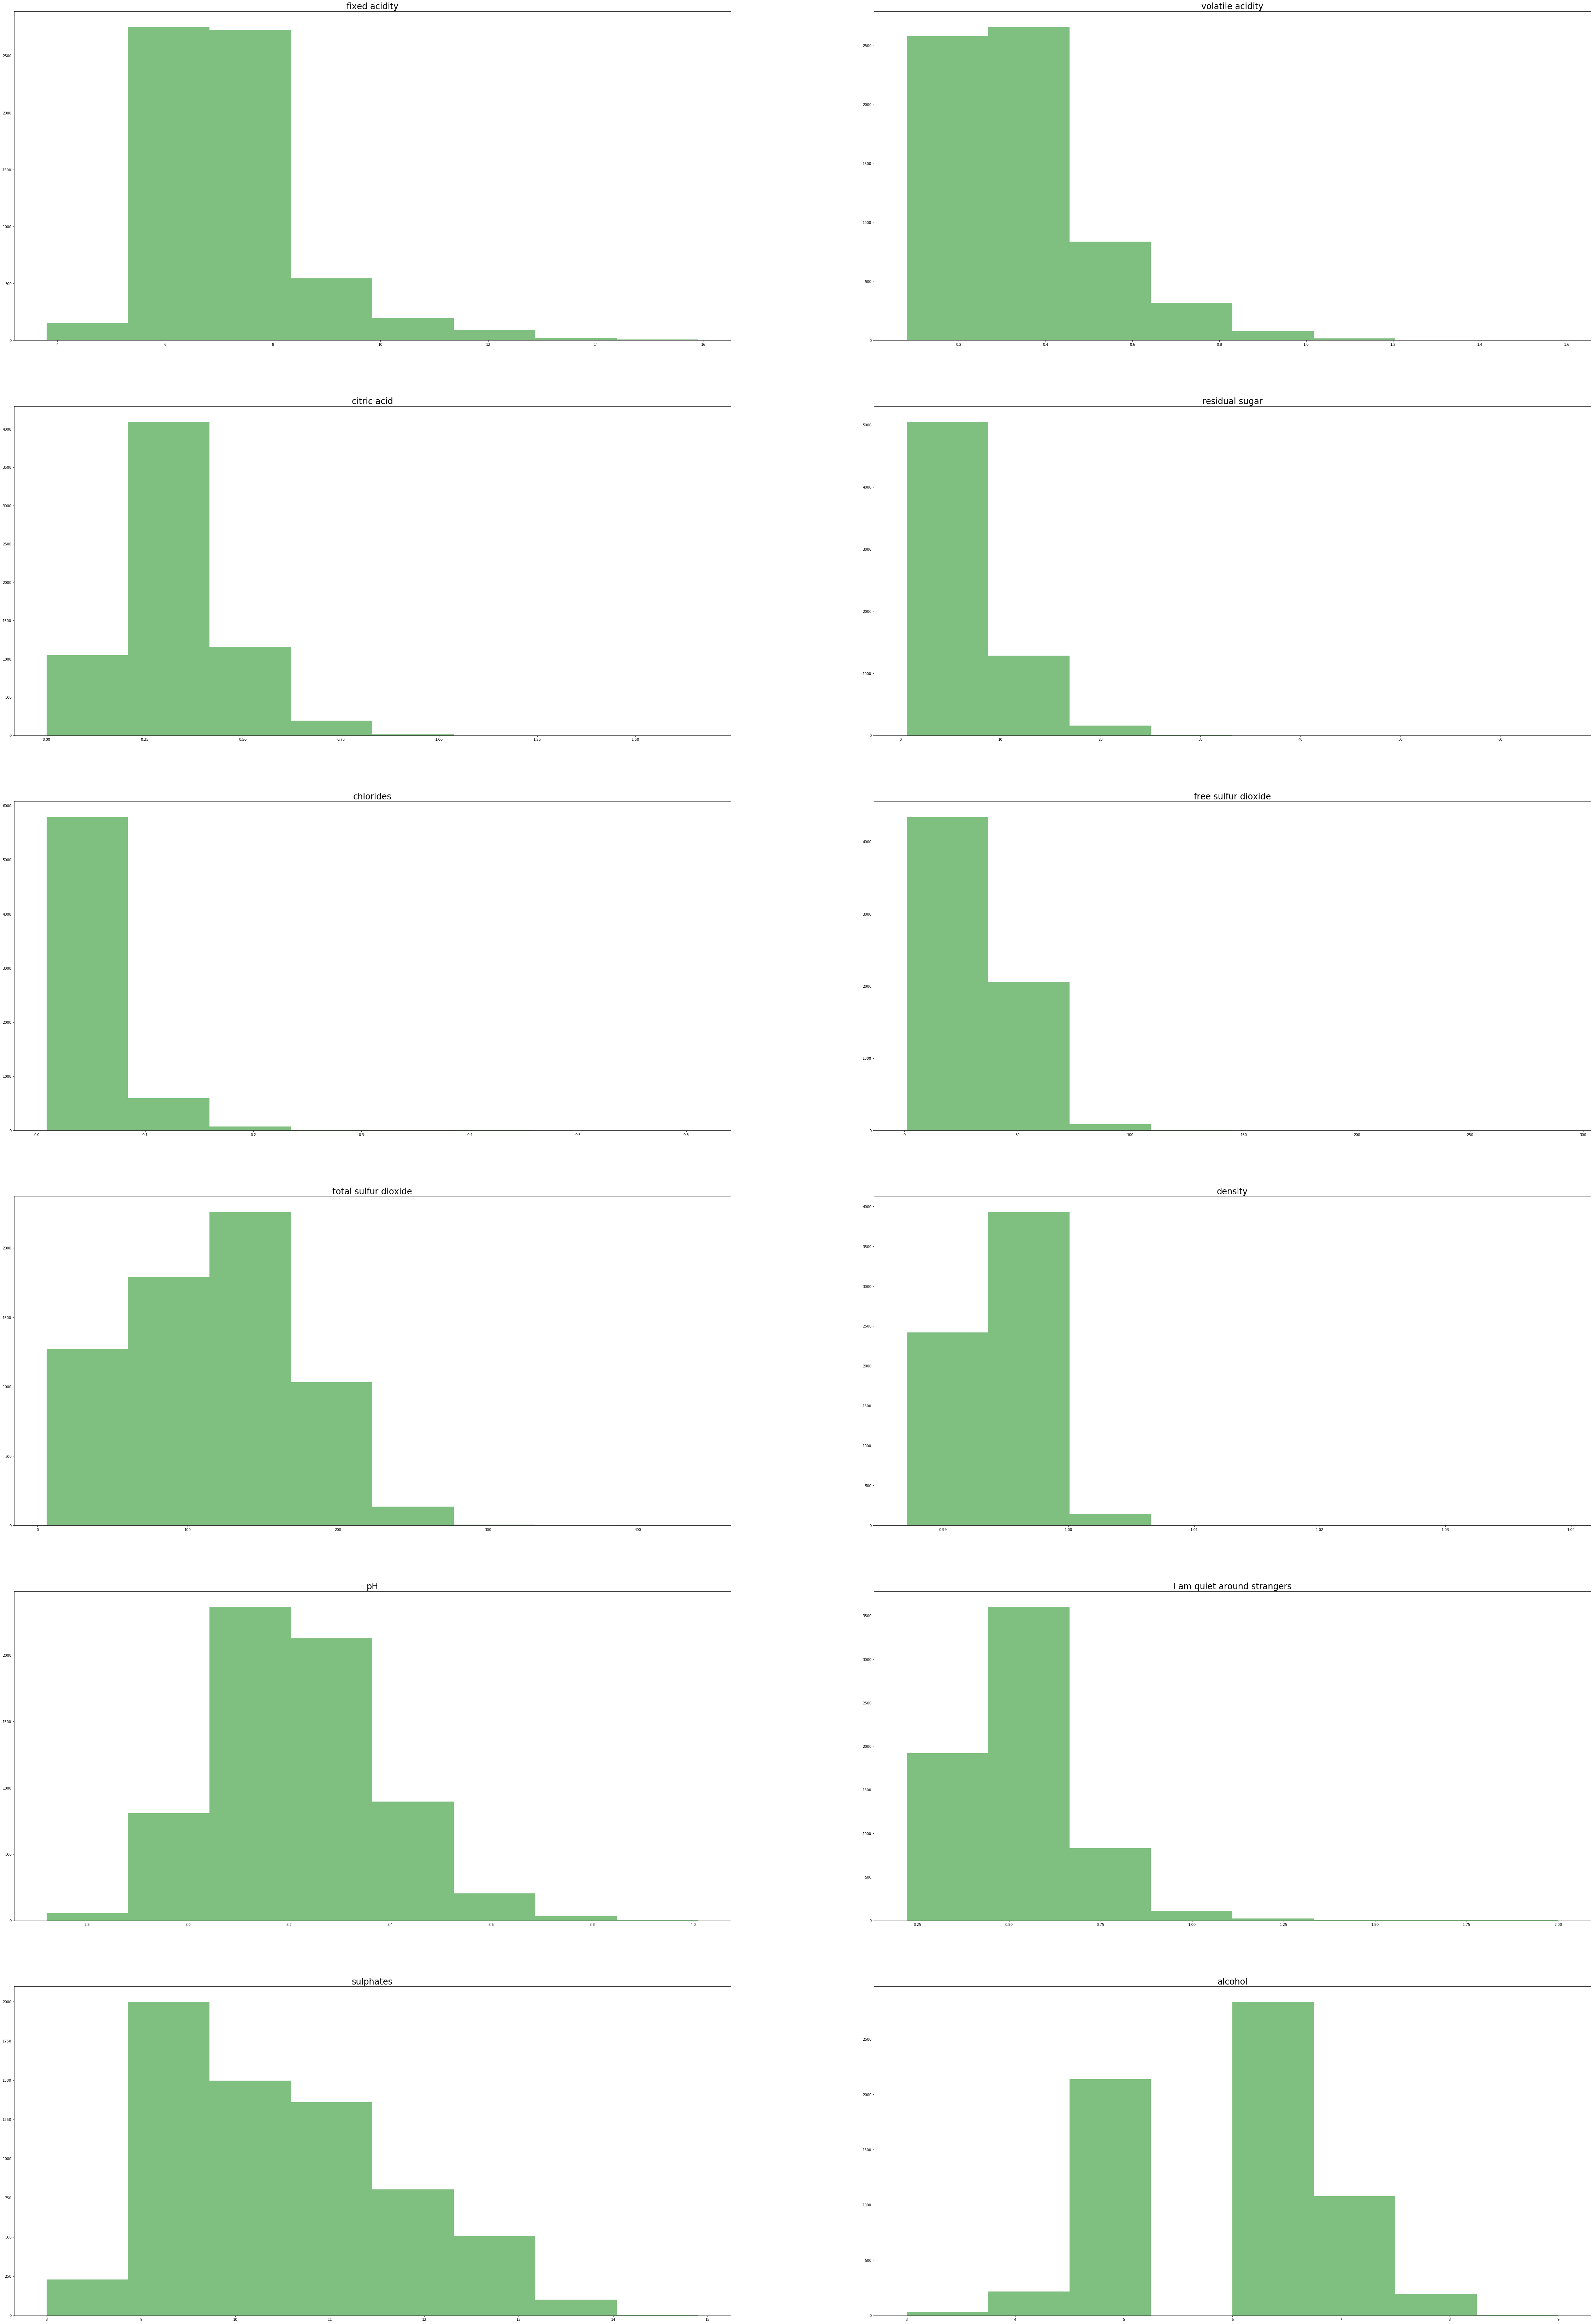

In [7]:
# Defining a function to visualize the questions and answers distribution

plt.figure(figsize=(80,120))
for i in range(1, 13):
    plt.subplot(6,2,i)
    plt.hist(data_wine[PC[i-1]], bins=8, color= 'green', alpha=.5)
    plt.title(pc_questions["PC"+str(i)], fontsize=24)

## HDBSCAN
Na początku importujemy bibliotekę HDBSCAN. Następnie tworzymy odpowidnią instancję klasy HDBSCAN. Podczas jej tworzenia użytkownik ma możliwośc podania następujących opcji: 
- **algorithm** - Okresla jaki algorytm zostanie użyty. hdbscan oferuje różne warianty w zależności od różnych danych. Domyślnie wybiera on najlepszą z dostepnych metod, jednakże można wymusić wykorzystanie konkretnej metody. Lista zawiera opcje best, generic, prims_kdtree, prims_balltree, boruvka_kdtree oraz boruvka_balltree.
- **allow_single_cluster** - Domyslnie HDBSCAN* nie zezwala na powstawanie jednoelementowych klastrów, jednakże można zezwolić na tego typu grupy. 
- **alpha** - parametr odpowiadający za skalowanie odległości w algorytmie Robust Single Linkage (silnego klastrowania z pojedynczym łączeniem).
- **approx_min_span_tree** - Czy zaakceptować tylko przybliżone minimalne drzewo opinające. W przypadku niektórych algorytmów może to zapewnić znaczne przyspieszenie, ale uzyskane w ten sposób grupowanie może być nieznacznie niższej jakości. Jeśli jednak istotne jest uzyskanie dokładnego grupowania kosztem wydajności, można ustawić ten parametr na False. 
- **cluster_selection_epsilon** - Próg odległości. Klastry poniżej tej wartości zostaną scalone.
- **cluster_selection_method** - Metoda stosowana do wybierania klastrów ze skondensowanego drzewa. Celem jest znalezienie najbardziej trwałych klastrów bazując na przyroście masy prawdopodobieństwa. Alternatywnie można zamiast tego wybrać klastry patrąc na liście drzewa - zapewnia to najdrobniejsze i jednorodne skupiska. Dostępne są opcje *eom* oraz *leaf*.
- **core_dist_n_jobs** - liczba zrównoleglonych obliczeń w przypadku podstawowych obliczeń odległości (jeśli jest obsługiwana przez określony algorytm).
- **gen_min_span_tree** - Czy generować minimalne drzewo rozpinające, z uwzględnieniem odległości wzajemnej osiągalności do późniejszej analizy.
- **leaf_size** -W przypadku wykorzystania jednego z algorytmów drzewa przestrzennego (kdtree lub balltree), parametr ten stanowi liczbę punktów w węźle liścia drzewa. Nie zmienia to wynikowego klastrowania, ale może mieć wpływ na czas wykonywania algorytmu.
- **match_reference_implementation** - flaga ta umożliwia zgodność z implementacją referencyjną algorytmu, napisaną w Javie. 
- **memory** - Służy do buforowania danych wyjściowych obliczeń drzewa. Domyślnie buforowanie nie jest wykonywane.
- **metric** - Metryka używana podczas obliczania odległości między wystąpieniami w szyku elementów. 
- **min_cluster_size** - minimalny rozmiar klastra. Poniżej tej wartości ellementy uznawane są za szum i nie będą uwzględniane w klastrach. 
- **min_samples** - Minimalna wymagana liczba punktów w sąsiedztwie należąca do klastra, by element został uznany jako core point.
- **p** - parametr odpowiedzialny za *truncate_mode*.
- **prediction_data** -Czy generować dodatkowe dane w pamięci podręcznej do przewidywania etykiet lub wektorów przynależności.

Za pierwszym razem wszystkie parametry pozostaną domyślne, dopiero w koljnych krokach będą one modyfikowane tak, by uzyskać optymalne efekty.   

In [8]:
import hdbscan

clusterer = hdbscan.HDBSCAN()

Bazując na danym zbiorze danych, możemy wykorzstać nowo stworzony obiekt by dopasować model, natomiast zwróci on obiekt będący klastrem danych. 

In [9]:
clusterer.fit(data_wine)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

Efektem metody fit jest klasteryzacja na zadanym zbiorze. Wyniki przechowywane są w atrybucie labels_ w postaci tablicy Integerów. Te elementy (w tym przypadku wina) które należą do tego samego klastra beda miały przypiane ten sam numer. Numerowanie zaczyna się od zera. Najwyższy numer oznacza ostani klaster a jadnocześnie ich całkowitą liczbę.

In [10]:
predictions = clusterer.labels_
predictions_set = set(predictions)

In [11]:
clusterer.labels_.max()

179

W podstawowym przypadku, bez manipulowania żadną z wartości parametrów, spośród 6496 rodzajów butelek udało się uzyskać 179 klastrów. Co istotne, HDBSCAN jest wrażliwy na szum - stąd też elementy które nie zostały zakwalifikowane do żandej z grupy oznacza się poprzez -1. Ponado biblioteka hdbscan implementuje tzw. soft clustering (inaczej klastrowanie rozmyte), które oznacza prawdopodobieństwo przynależności do danej klasy w skali od 0.0 do 1.0, gdzie 0 oznacza próbkę która w zupełności nie należy do danego klastra (przykładowo szum dostanie taką ocenę), natomiast 1.0 oznacza element idealnie pasujący do klastra (uwaga - nie oznacza to że jest on punktem centralnym). Informację o wartościach dla każdego punktu można uzyskać poprzez pole probabilities_.

In [12]:
clusterer.probabilities_ 

array([0.        , 0.9543368 , 1.        , ..., 0.98946241, 0.        ,
       0.        ])

### Wizualizacja
Aby zwizualizować uzyskany efekt klasyfikacji konieczne będzie redukcja do dwóch wymiarów. Powołując się na publikację Sebastiana Raschki, "Uczenie Maszynowe", Analiza głownych składowych (ang. *principal component analysis* - **PCA**) jest techniką nienadzorowanej, liniowej transformacji, powszechnie wykorzystywaną w różnych dziedzinach, takich jak badawcza analiza danych czy usuwanie szumów w transakcjach giełdywych, ale najczęściej w przypadku redukcji wymiarowości. Analiza PCA umożliwia identyfikowanie wzorców danych pomiędzy cechami. Innymi słowy, zadaniem analizy głównych składowych jest wyszukiwnie kierunków maksymalnej wariancji w wielowymiarowej przestrzeni i rzutowanie ich na nową podprzestrzeń zawierającą tyle samo bądź mniej wymiarów, co pierwotna przestrzeń cech. Osie ortogonalne (główne składowe) rzutowane w nowej podprzestrzeni symbolizują kierunki maksymalnej wariancji przy wprowadzonym ograniczeni 

In [13]:
# In order to visualize in 2D graph I will use PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_fit = pca.fit_transform(data_wine)

df_pca = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
df_pca['Clusters'] = predictions
df_pca.head()

,PCA1,PCA2,Clusters
0,-84.110701,-0.153072,-1
1,-48.778985,5.839312,130
2,-63.734130,-0.884222,133
3,-57.481355,-0.343755,-1
4,-84.110701,-0.153072,-1


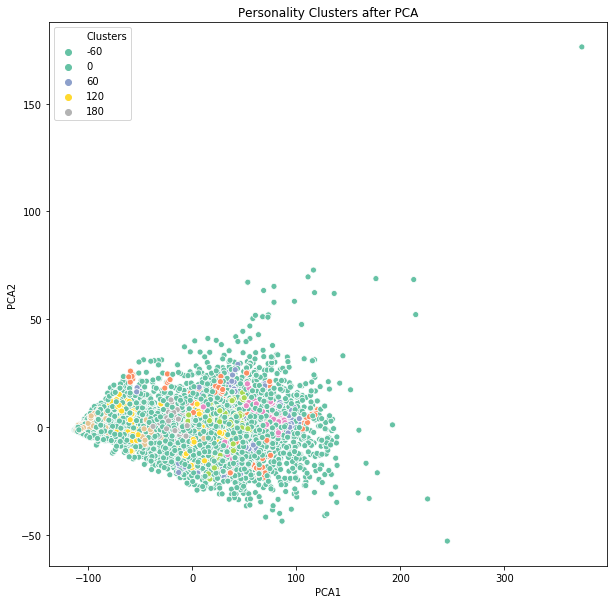

In [14]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Clusters', palette='Set2', alpha=1)
plt.title('Personality Clusters after PCA');

Należy zadać sobie pytanie, jak wygląda hierarchia klastrów - które z nich są blisko siebie lub mogą być połączone, a które są daleko od siebie. Informacje na temat hierarchii można uzyskać poprzez pole *condensed_tree_* obiektu typu clusterer. Lambda stanowi odległość euklidesowa między punktami.

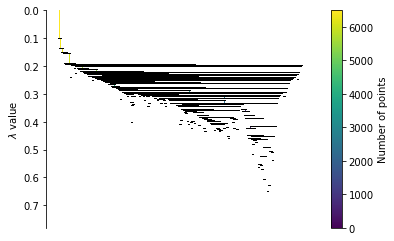

In [15]:
clusterer = hdbscan.HDBSCAN()
clusterer.fit(data_wine).condensed_tree_.plot()

Możemy zobaczyć uzyskaną hierarchię w postaci dendrogramu, szerokość (i kolor) każdej gałęzi reprezentuje liczbę punktów w klastrze na tym poziomie. Jeśli chcemy wiedzieć, które gałęzie zostały wybrane przez algorytm HDBSCAN*, możemy przekazać *select_clusters=True*. Możliwe jest również przekazanie palety selekcji, aby pokolorować selekcje zgodnie z etykietą klastra.

/home/michal/anaconda3/lib/python3.7/site-packages/hdbscan/plots.py:383: UserWarning: Infinite lambda values encountered in chosen clusters. This might be due to duplicates in the data.
  warn('Infinite lambda values encountered in chosen clusters.'


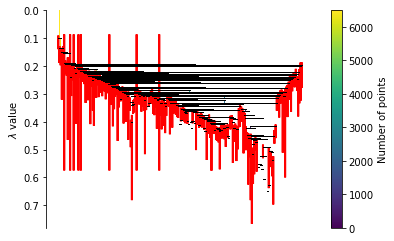

In [16]:
clusterer = hdbscan.HDBSCAN()
clusterer.fit(data_wine).condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

Powyższy wykres pokazuje, że nie da się wskazać konkretnych klastrów, a bez podania żadnych parametrów w konstruktorze algorytm wyłapuje głównie szum, pomijając istotne wzorce.   

## Modyfikacja poszczególnych parametrów metody HDBSCAN*
Nas pierwszy ogień pójdzie parametr min_cluster_size. Załóżmy, że przy idealnym podziale chcielibysmy, by wszystkie elementy zostały zakwalifikowane do jakiegoś klastera, oraz by liczba grup wynosiła 10. W tym celu liczbę elementów podzielilibyśmy pzez 10, ale biorąc poprawkę na szum, zwiększymy mianownik do 20. 

In [17]:
row_numer = data_wine["density"].count()
min_cluster = int(round(row_numer/20))
min_cluster

325

In [18]:
min_samples=min_cluster
type(min_samples)

int

aby uniknąć ciągłego kopiowania i wklejania kodu definujemy funkcje calculate_and_display, któej zadaniem jest przeliczenie algorytmu dla nowych parametrów oraz narysowanie nowego grafu.

In [19]:
def display_graph(df_pca):
    plt.figure(figsize=(10,10))
    sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Clusters', palette='Set2', alpha=1)
    plt.title('Personality Clusters after PCA');

def calculate(clusterer):
    clusterer.fit(data_wine)
    predictions = clusterer.labels_
    pca = PCA(n_components=2)
    pca_fit = pca.fit_transform(data_wine)
    df_pca = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
    df_pca['Clusters'] = predictions
    return df_pca

def calculate_and_display(clusterer):
    df_pca = calculate(clusterer)
    display_graph(df_pca)

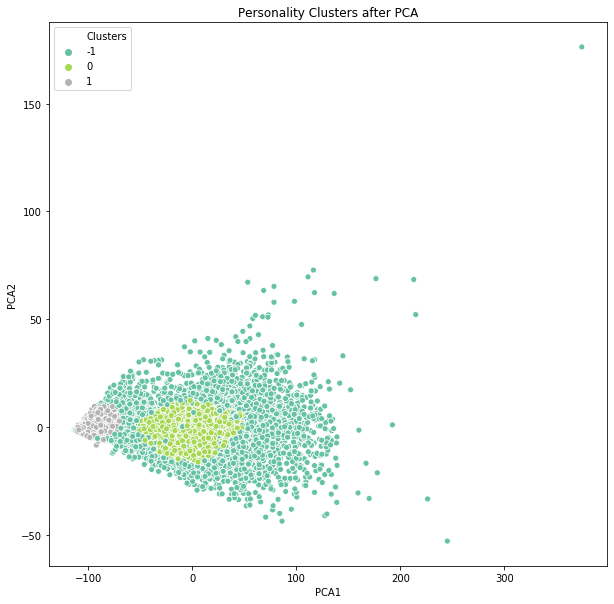

In [20]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster)
calculate_and_display(clusterer)

Dostaliśmy dwa klastry, jednakże kosztem utraty dosyć dużej liczby informacji. Sprawdźmy jednak co się stanie, gdy weźmiemy mniej elementów do klastra, np. dziesięciokrotnie mniej. Ponadto, ponieważ liczba obserwacji jest relatywnie niska, możemy pozwolić sobie na ustawienie flagi approx_min_span_tree na False. 

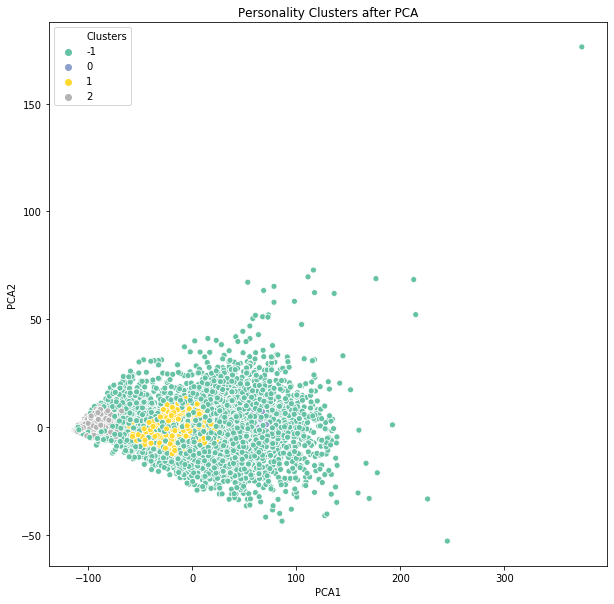

In [58]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=int(min_cluster/10), 
                           approx_min_span_tree=False)

calculate_and_display(clusterer)

Jak widać dostaliśmy 3 klastry, jednak klaster 1 i 0 łączą się przy wyższych wartościach parametru. Może to jedak sugerowac, że duża część punktów znajdująca się po prawej stronie chmury jest "niezagospodarowana", stąd też warto zastanwoić się, czy da się znaleźć wzór na tym obszarze.

Liczba danych klasyfikowanych jako szum może być kontrolowana poprzez parametr min_samples. Domyślnie, jego wartość jest taka sama, jak min_cluster_size, jednakże można go modyfikować wedle uznania. Im niższa wartość, tym mniej szumu uzyskamy, jednakże w pewnym momencie można przesadzić i zacżąć uznawać szum za istotne dane.  See _min_samples_label for more details.

Porównamy teraz jak zmieni się klasteryzacja, gdy początkową wartośc min_cluster przypiszemy nie do parametru min_cluster_size, ale do min_samples. Ponadto, bazując na doświadczeniach z poprzedniego pukntu, w ramach ekperymentu zmniejszamy wartość min_cluser_size o połowę.

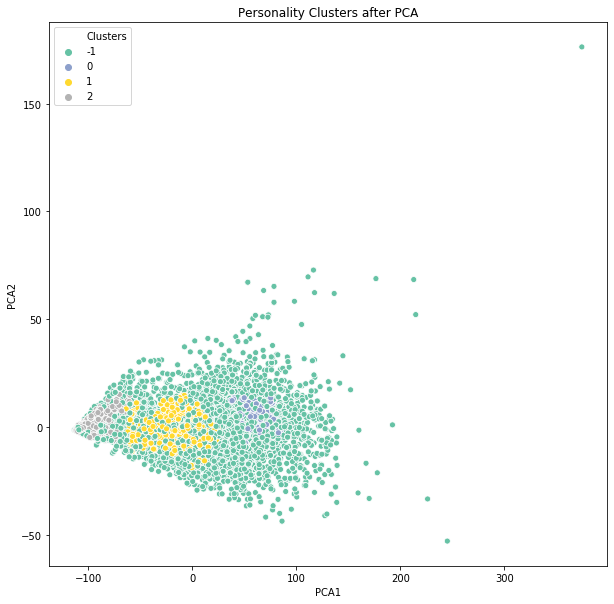

In [40]:
clusterer = hdbscan.HDBSCAN(min_samples=7,min_cluster_size=int(min_cluster/2), approx_min_span_tree=False)
calculate_and_display(clusterer)

Tym razem nie tylko udało się znacznie mocniej zarysować kształt zbioru po proawe stronie, ale także środkowy zbiór stał się o wiele gęstszy. 

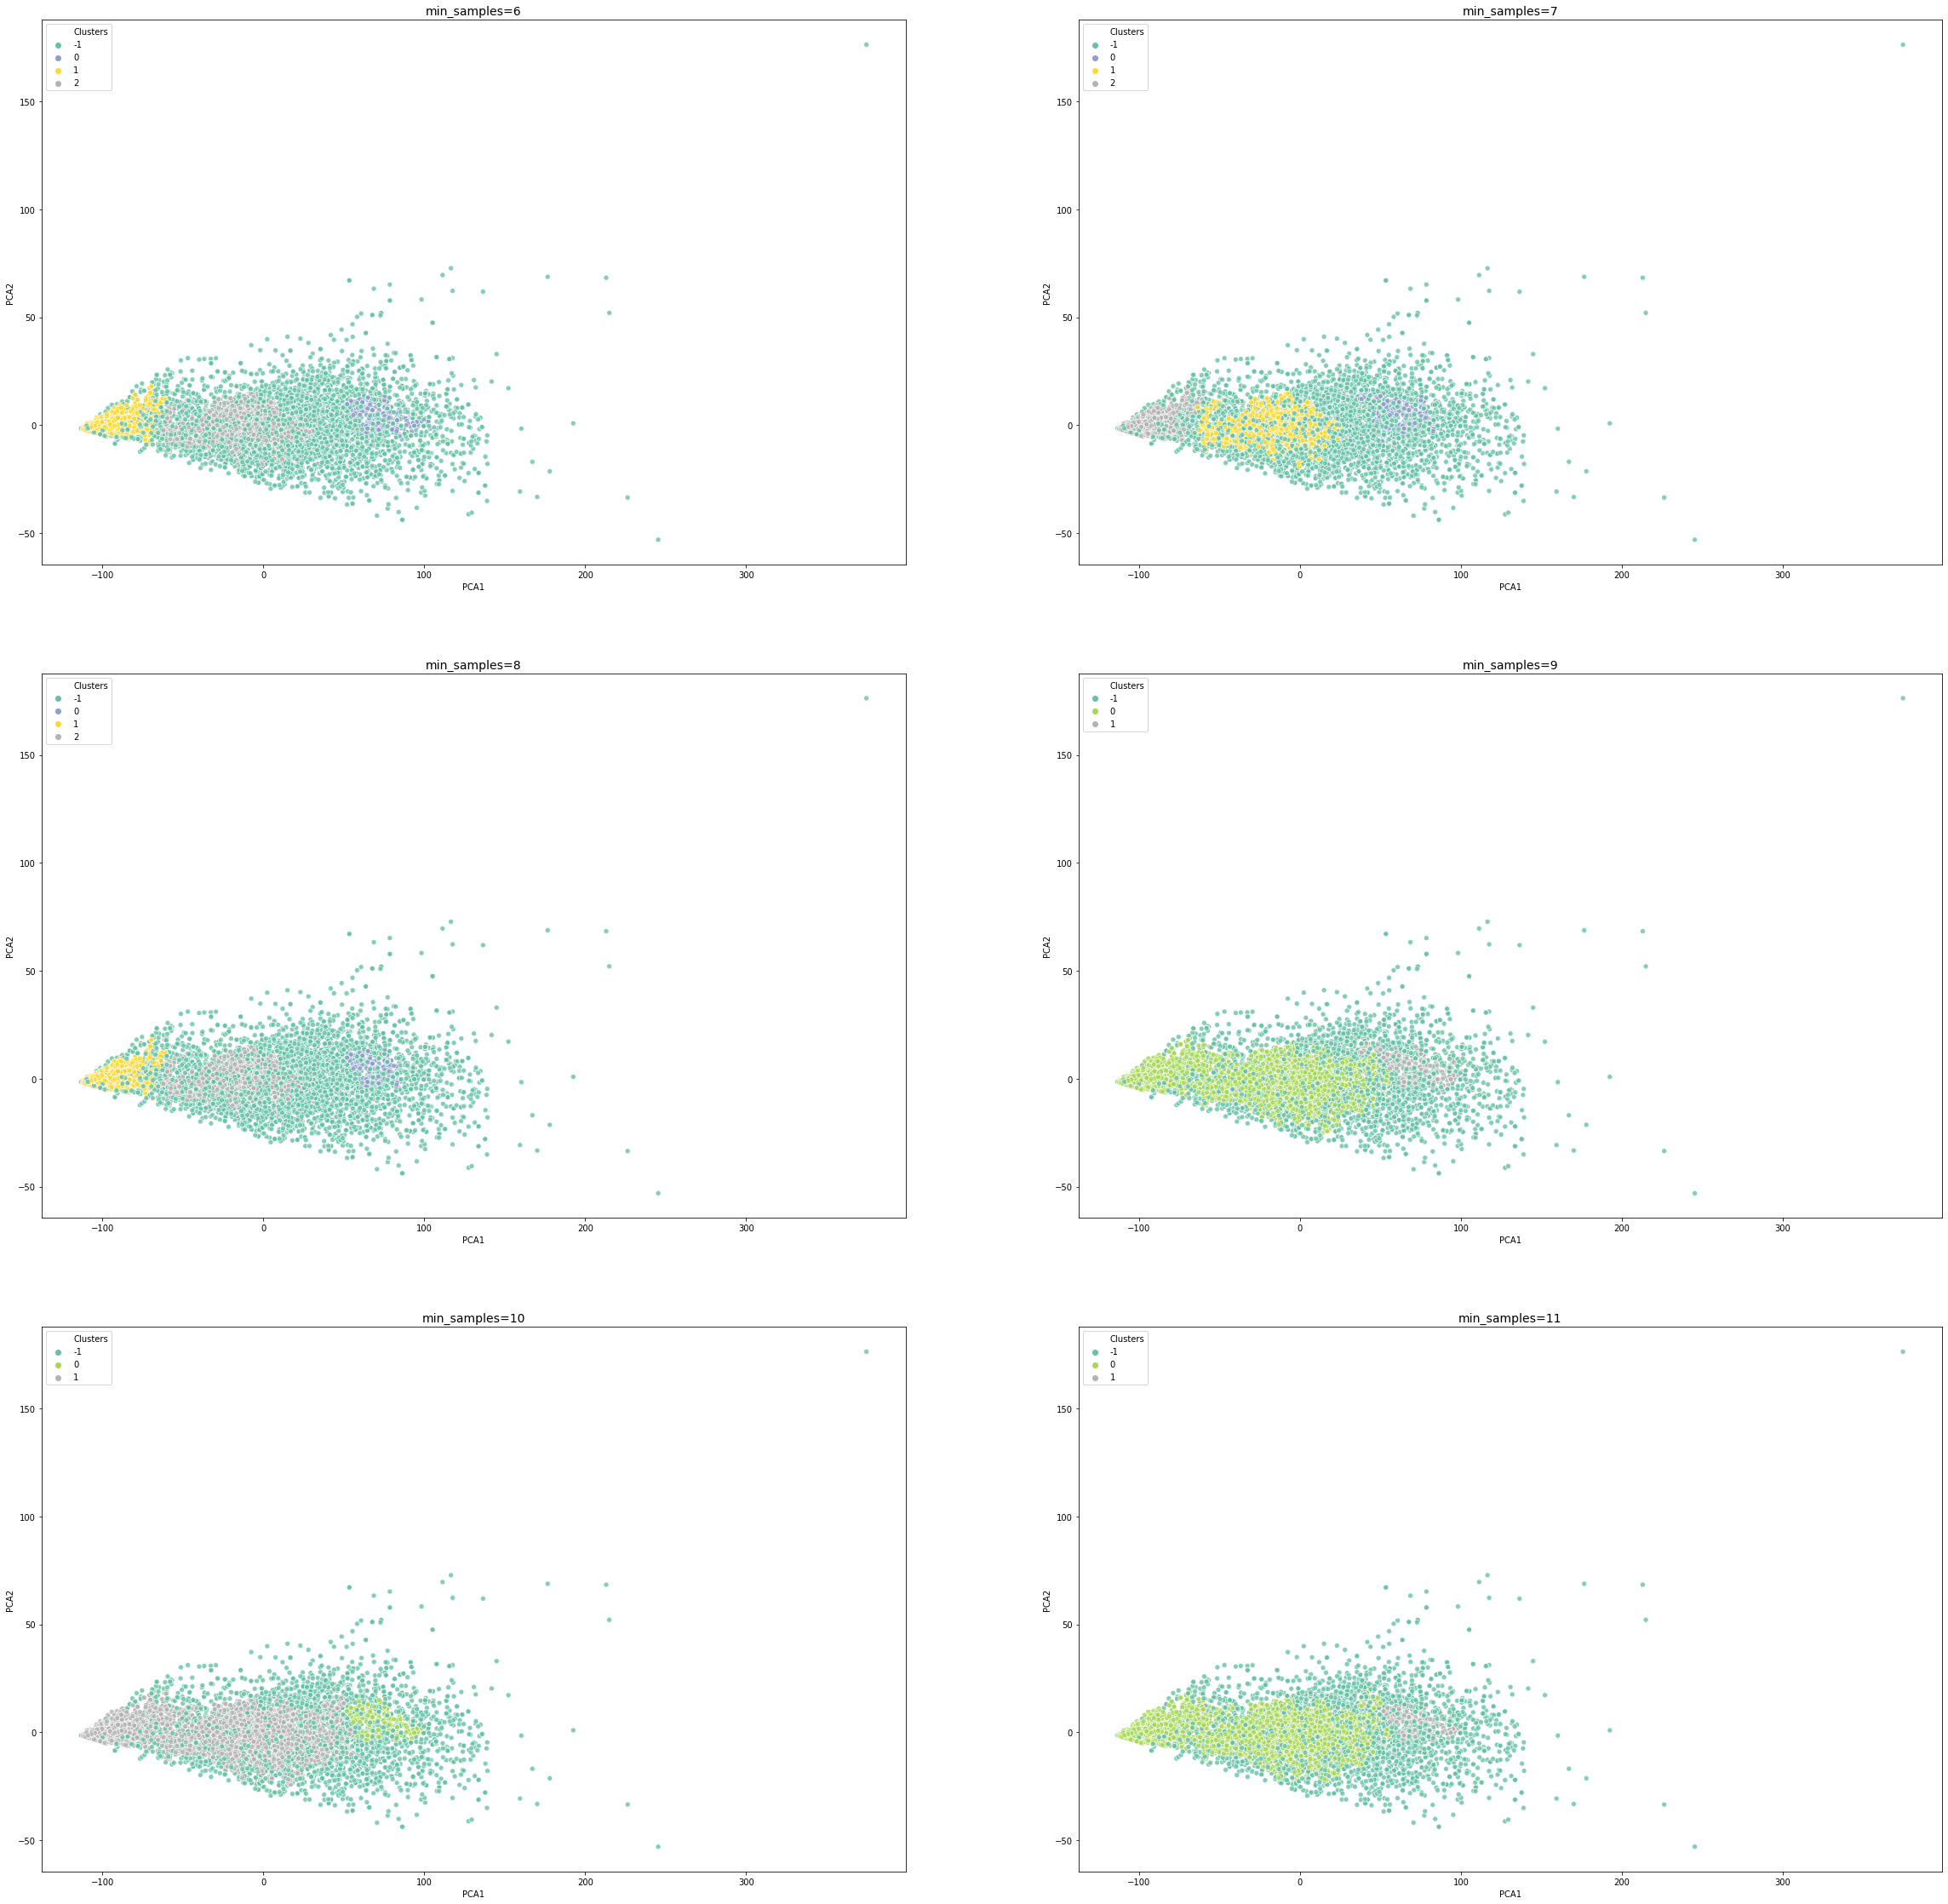

In [41]:
plt.figure(figsize=(40,40))
for i in range(1,7):
    clusterer = hdbscan.HDBSCAN(min_samples=i+5,min_cluster_size=int(min_cluster/2), approx_min_span_tree=False)
    plt.subplot(3,2,i)
    df_pca=calculate(clusterer)
    sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Clusters', palette='Set2', alpha=0.8)
    plt.title("min_samples="+str(i+5), fontsize=14)

Patrząc na graficzną prezentacje wyników wydaje się, że najciekawsze do dalszej analizy są te, dla któych wartość min_samples wynosi 9 (co daje 2 klastry) lub 6 (3 klastry). Warto jednak sprawdzić te przypuszczenia za pomocą opcji *condensed_tree_*.

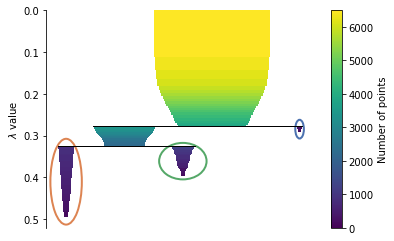

In [42]:
clusterer = hdbscan.HDBSCAN(min_samples=6,min_cluster_size=int(min_cluster/2), approx_min_span_tree=False)
clusterer.fit(data_wine).condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

Dla przypomnienia, wraz ze zmianą λ>0 f-poziomowe zbiory zagnieżdżają się, tworząc nieskończone drzewo, które określa się mianem drzewa klastrów (ang.cluster tree). Lambda (*lambda_val*) jest to wartość równa 1/distance, przy której gałąź potomna opuszcza kalster.

Po założeniu pewnego poziomu lambda należy znaleźć poszczególne klastry. Odbywa się to poprzez łączenie ,,pobliskich'' punktów ze sobą. ,,Sąsiedztwo'' jest określane przez aktualny poziom gęstości zdefiniowany przez 𝜆 i określa się, że dwa punkty są wystarczająco blisko, jeśli ich odległość euklidesowa jest mniejsza niż 𝜆.

Określoną hierarchię przedstawia dendogram, szerokość (i kolor) każdej gałęzi reprezentuje liczbę punktów w klastrze na tym poziomie. Aby sprawdzić, które gałęzie zostały wybrane przez algorytm HDBSCAN*, można ustalić wartość parametru *select_clusters = True*. Można również określić paletę kolorów, aby pokolorować selekcje zgodnie z etykietą klastra.

Patrząc na wykres można zauważyć, że niebieski klaster formułuje się jednie przez chwilę, po czym wraz ze zmianą wartości lambdy znika, gdy jesgo rozmiar spada poniżej wartości parametru min_cluster_size, w przeciwieństwie do zielonego klastra - ten po uformowaniu trwa najdłużej. To, jak zachowa się klaster, zależy od wspomnianej wcześniej wartości dystansu - przykładowo poziom lambda równy 0.5 oznacza, że dystans wynosi 2, natomiast dla 0.1 jest to wartość 10.

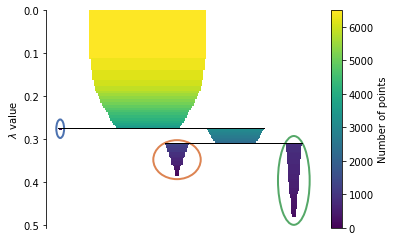

In [43]:
clusterer = hdbscan.HDBSCAN(min_samples=7,min_cluster_size=int(min_cluster/2), approx_min_span_tree=False)
clusterer.fit(data_wine).condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

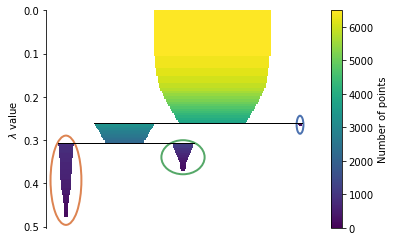

In [44]:
clusterer = hdbscan.HDBSCAN(min_samples=8,min_cluster_size=int(min_cluster/2), approx_min_span_tree=False)
clusterer.fit(data_wine).condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

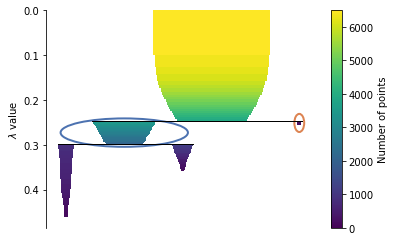

In [45]:
clusterer = hdbscan.HDBSCAN(min_samples=9,min_cluster_size=int(min_cluster/2), approx_min_span_tree=False)
clusterer.fit(data_wine).condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

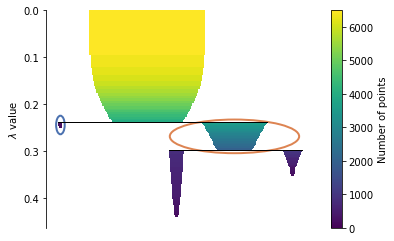

In [46]:
clusterer = hdbscan.HDBSCAN(min_samples=10,min_cluster_size=int(min_cluster/2), approx_min_span_tree=False)
clusterer.fit(data_wine).condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

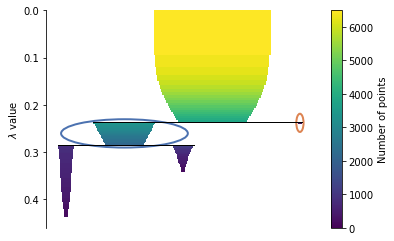

In [47]:
clusterer = hdbscan.HDBSCAN(min_samples=11,min_cluster_size=int(min_cluster/2), approx_min_span_tree=False)
clusterer.fit(data_wine).condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

### Wykorzystanie innych metryk 
Istotną funkcją implementacji algorytmu HDBSCAN* jest możliwość zmiany metryki. Jest to przydatna funkcja w przypadku, gdy metryka Euklidesowa wydaje się być nieodpowiednia. Poniżej znajduje się porównanie metryki euklidesowej oraz manhattan. Jak widać, w tym komnkretnym przypadku lepiej radzi sobie domyślny wybór.  

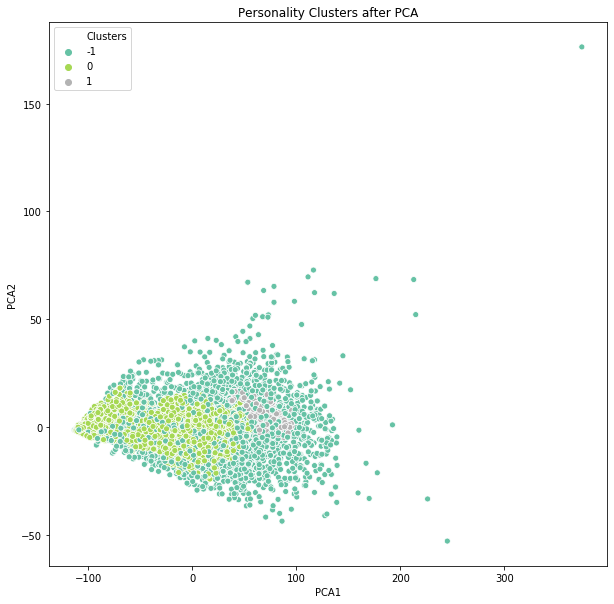

In [48]:
clusterer = hdbscan.HDBSCAN(min_samples=9,min_cluster_size=int(min_cluster/2), approx_min_span_tree=False, metric='euclidean')
calculate_and_display(clusterer)

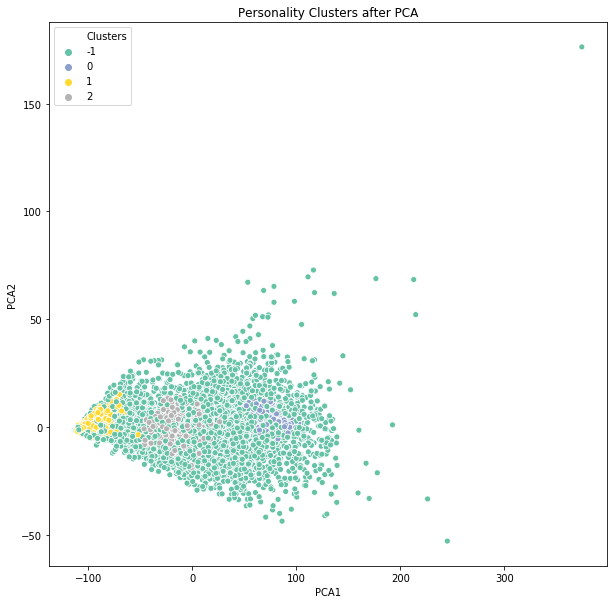

In [49]:
clusterer = hdbscan.HDBSCAN(min_samples=9,min_cluster_size=int(min_cluster/2), approx_min_span_tree=False, metric='manhattan')
calculate_and_display(clusterer)

### Różne wartości cluster_selection_epsilon
W niektórych przypadkach istotny jest wybór niskiej wartości min_cluster_size, kiedy istotne sa nawet niewielkie klastry. Jeśli jednak badany zestaw danych zawiera również podziały o dużej koncentracji elementów, to ustawienie parametru może skutkować dużą liczbą mikro-klastrów. Wybranie wartości dla cluster_selection_epsilon pomaga scalić klastry w tych obszarach. Innymi słowy, zapewnia to, że klastry poniżej podanego progu nie są dalej dzielone.

Wybór wartości parametru cluster_selection_epsilon zależy od określonych odległości między punktami danych. Na przykład ustawienie wartości na 0.5, jeśli nie chce się oddzielać klastrów oddalonych od siebie o mniej niż 0.5 jednostki. To zasadniczo wyodrębni klastry DBSCAN* dla epsilon = 0.5 ze skondensowanego drzewa klastrów, ale pozostawi nietknięte klastry HDBSCAN*, które pojawiły się w odległościach większych niż 0.5.

### Wykrywanie wartości odstających 

Biblioteka hdbscan wspiera również algorytm GLOSH do wykrywania wartości odstających i robi to w ramach klastrowania metodą HBBSCAN. Metoda GLOSH związana jest ze starszymi tego typu podejściami, jak LOF albo LOCI. Jest szybka i elastyczna, a do tego obsługuje lokalne wartości krańcowe. Oznacza to, że może wykryć wartości odstające, które mogą znacznie różnić się od punktów w lokalnym otoczeniu pojedynczego kalstra, ale które niekoniecznie są wartościami odstającymi globalnie. 

### Przewidywanie przynależności do klastrów dla nowych punktów
Często przydatne jest jednorazowe wytrenowanie modelu na dużej ilości danych, a następnie wielokrotne wykonywanie zapytań dotyczących modelu przy użyciu niewielkich ilości nowych danych. Jednakże jest to trudne dla HDBSCAN*, ponieważ jest to metoda transdukcyjna - nowe punkty danych mogą (a wręcz powinny powinny) być w stanie zmienić podstawowe grupowanie. Oznacza to, że biorąc pod uwagę nowe informacje, sensowne może być utworzenie nowego klastra, podzielenie istniejącego klastra lub połączenie dwóch wcześniej oddzielnych grup. Jeśli rzeczywiste zbiory (a tym samym ich etykiety) zmieniają się z każdym nowym punktem danych, niemożliwe staje się porównanie przypisań klastrów między takimi zapytaniami. 


Jedyną opcją, by wykorzystując algorytm nie tylko analizować już zastany zbiór danych, ale też przewidywać przynależność dla nowych elementów, jest utrzymanie raz ustalonego klastrowania, a następnie przyporządkowywanie nowych elementów do klastrów przy założeniu, że nowo uzyskany element nie wpływa na ustalony podział. W praktyce sprowadza się to do określenia, gdzie w skondensowanym drzewie spadnie nowy punkt danych, zakładając, że nie zmienia się owego drzewa. Pozwala to na zoptymalizowaną operację obliczenia przewidywanego klastra dla nowego punktu danych.

W przypadku biblioteki hdbscan jest to zaimpelmentowane jako funkcja *approximate_predict()*.

### Soft Clustering w HDBSCAN*
Soft clustering is a new (and still somewhat experimental) feature of the hdbscan library. It takes advantage of the fact that the condensed tree is a kind of smoothed density function over data points, and the notion of exemplars for clusters. If you want to better understand how soft clustering works please refer to How Soft Clustering for HDBSCAN Works.

## Scenariusz pierwszy - jak najwięcej rodzajów win, cena nie gra roli

## Scenariusz drugi - wyspecjalizowanie się w dwóch typach wina i rotowanie nimi w zależności od ceny. 